cell 0 =  import yang harus di import 

GPU memory growth

In [1]:
import tensorflow as tf
print("TF:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))
print("Built with CUDA:", tf.test.is_built_with_cuda())

# optional: biar gak makan VRAM langsung
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)


TF: 2.10.1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True


CELL 1 — Config & Dataset Path

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from tensorflow import keras
from tensorflow.keras import layers

# ===== CONFIG =====
IMG_SIZE = 256
BATCH_SIZE = 2       # kalau VRAM kecil: 4 / 2
EPOCHS = 75

# Path dataset Roboflow (sesuaikan kalau folder kamu beda)
TRAIN_IMG_DIR = "lane_detection/train/images"
TRAIN_MASK_DIR = "lane_detection/train/masks"
VAL_IMG_DIR   = "lane_detection/valid/images"
VAL_MASK_DIR  = "lane_detection/valid/masks"

CELL 2 — Load Image + Mask (Roboflow-Friendly)

In [3]:
def load_images_and_masks(img_dir, mask_dir, img_size=IMG_SIZE):
    images, masks = [], []

    image_files = sorted([
        f for f in os.listdir(img_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

    for img_file in image_files:
        img_path = os.path.join(img_dir, img_file)

        # mask roboflow biasanya nama sama tapi .png
        mask_file = os.path.splitext(img_file)[0] + ".png"
        mask_path = os.path.join(mask_dir, mask_file)

        if not os.path.exists(mask_path):
            # skip kalau mask ga ketemu
            continue

        # --- image ---
        img = Image.open(img_path).convert("RGB")
        img = img.resize((img_size, img_size))
        img = np.array(img, dtype=np.float32) / 255.0

        # --- mask (binary) ---
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((img_size, img_size))
        mask = np.array(mask, dtype=np.float32) / 255.0
        mask = (mask > 0.5).astype(np.float32)  # binarize
        mask = np.expand_dims(mask, axis=-1)    # (H,W,1)

        images.append(img)
        masks.append(mask)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

print("Loading training data...")
train_images, train_masks = load_images_and_masks(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
print("Train:", train_images.shape, train_masks.shape)

print("Loading validation data...")
val_images, val_masks = load_images_and_masks(VAL_IMG_DIR, VAL_MASK_DIR)
print("Val  :", val_images.shape, val_masks.shape)


Loading training data...
Train: (2326, 256, 256, 3) (2326, 256, 256, 1)
Loading validation data...
Val  : (588, 256, 256, 3) (588, 256, 256, 1)


cell 3 = Quick sanity check

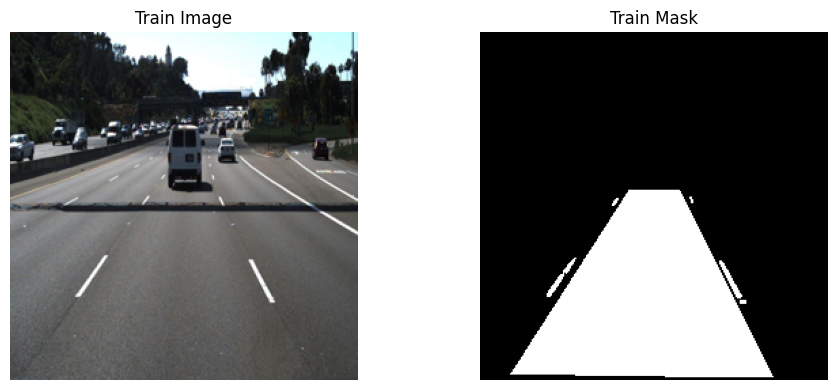

In [4]:
i = 0
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Train Image")
plt.imshow(train_images[i])
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Train Mask")
plt.imshow(train_masks[i,:,:,0], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()



CELL 4 — Custom U-Net

In [5]:
def build_unet_model(img_size=IMG_SIZE):
    inputs = keras.Input(shape=(img_size, img_size, 3))

    # Encoder
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    b = layers.Conv2D(256, 3, activation="relu", padding="same")(p3)
    b = layers.Conv2D(256, 3, activation="relu", padding="same")(b)

    # Decoder
    u5 = layers.UpSampling2D()(b)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(128, 3, activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(128, 3, activation="relu", padding="same")(c5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(64, 3, activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(64, 3, activation="relu", padding="same")(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(32, 3, activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(32, 3, activation="relu", padding="same")(c7)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c7)
    return keras.Model(inputs, outputs)

print("Building model...")
model = build_unet_model()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

print("Training model...")

Building model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                           

CELL 5 — tf.data pipeline

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

# pastikan dtype float32 biar hemat memori + kompatibel GPU
train_images = train_images.astype("float32")
train_masks  = train_masks.astype("float32")
val_images   = val_images.astype("float32")
val_masks    = val_masks.astype("float32")

# paksa pembuatan Dataset di CPU (jangan biarin TF naruh konstanta ke GPU)
with tf.device("/CPU:0"):
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
    val_ds   = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

train_ds = train_ds.shuffle(512).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

CELL 6 — TRAINING

In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/75
1163/1163 [==============================] - 125s 94ms/step - loss: 0.1847 - accuracy: 0.9252 - precision: 0.8949 - recall: 0.8005 - val_loss: 0.0998 - val_accuracy: 0.9627 - val_precision: 0.9206 - val_recall: 0.9333
Epoch 2/75
1163/1163 [==============================] - 143s 123ms/step - loss: 0.0986 - accuracy: 0.9650 - precision: 0.9294 - recall: 0.9334 - val_loss: 0.0987 - val_accuracy: 0.9643 - val_precision: 0.9229 - val_recall: 0.9372
Epoch 3/75
1163/1163 [==============================] - 144s 124ms/step - loss: 0.0781 - accuracy: 0.9711 - precision: 0.9388 - recall: 0.9486 - val_loss: 0.0863 - val_accuracy: 0.9651 - val_precision: 0.9612 - val_recall: 0.8982
Epoch 4/75
1163/1163 [==============================] - 145s 125ms/step - loss: 0.0742 - accuracy: 0.9726 - precision: 0.9418 - recall: 0.9514 - val_loss: 0.0904 - val_accuracy: 0.9646 - val_precision: 0.9252 - val_recall: 0.9359
Epoch 5/75
1163/1163 [==============================] - 147s 126ms/step - loss: 0

CELL 7 — Plot Training

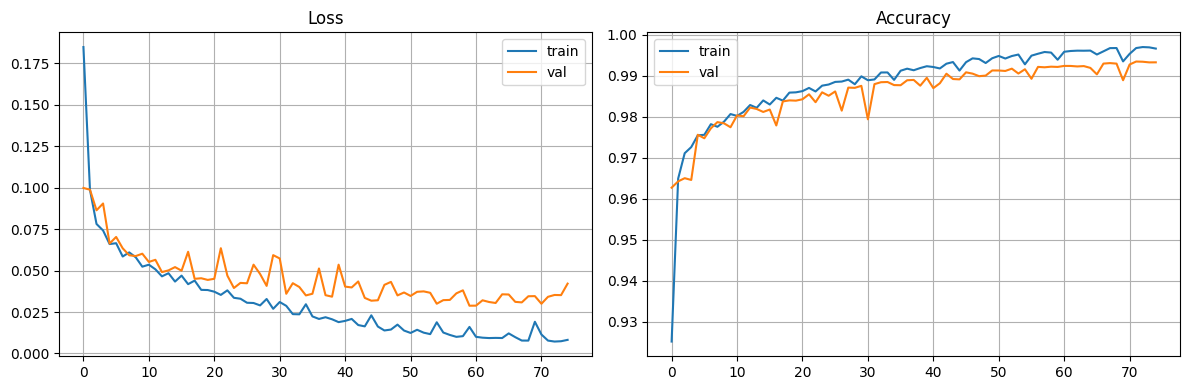

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


CELL 8 — Save Model

In [9]:
model.save("lane_model.h5")
print("Model saved as lane_model.h5")


Model saved as lane_model.h5


CELL 9 — Quick Visual Check (Masking)

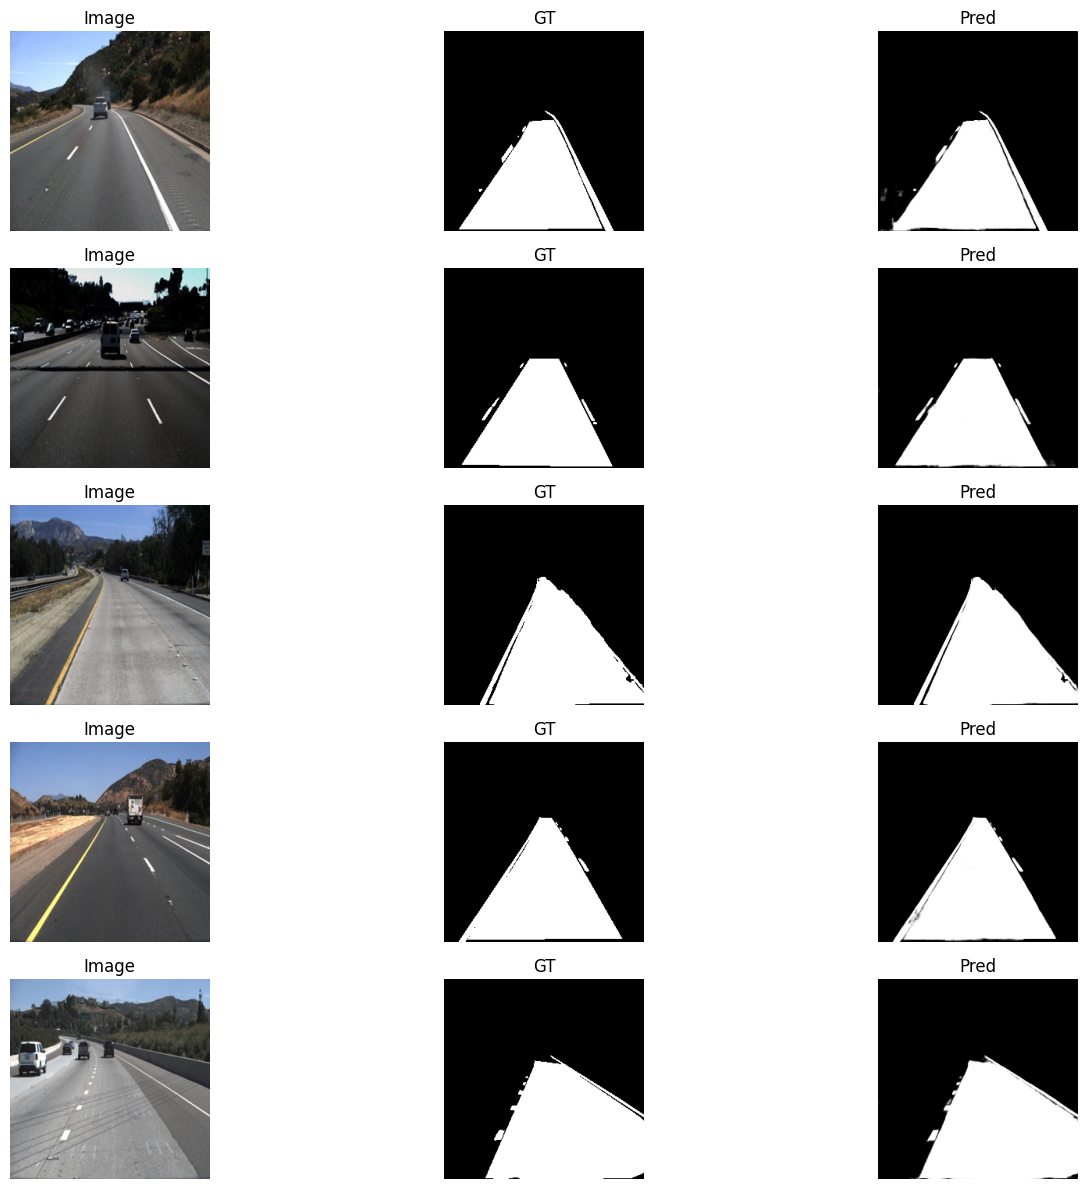

In [10]:
pred = model.predict(val_images[:5], verbose=0)

fig, axes = plt.subplots(5, 3, figsize=(15, 12))
for i in range(5):
    axes[i,0].imshow(val_images[i]); axes[i,0].set_title("Image"); axes[i,0].axis("off")
    axes[i,1].imshow(val_masks[i,:,:,0], cmap="gray"); axes[i,1].set_title("GT"); axes[i,1].axis("off")
    axes[i,2].imshow(pred[i,:,:,0], cmap="gray"); axes[i,2].set_title("Pred"); axes[i,2].axis("off")

plt.tight_layout()
plt.show()


CELL 10 — Confusion Matrix (Segmentation Metrics)


=== CONFUSION MATRIX (Pixel-wise) ===
Format: [[TN, FP],[FN, TP]]
[[28631050   150099]
 [  107493  9646526]]

=== METRICS ===
TN          : 28631050
FP          : 150099
FN          : 107493
TP          : 9646526
Accuracy    : 0.9933
Precision   : 0.9847
Recall      : 0.9890
F1          : 0.9868
IoU (Lane)  : 0.9740
Dice (Lane) : 0.9868
[OK] Saved confusion matrix figure to: confusion_matrix_lane.png


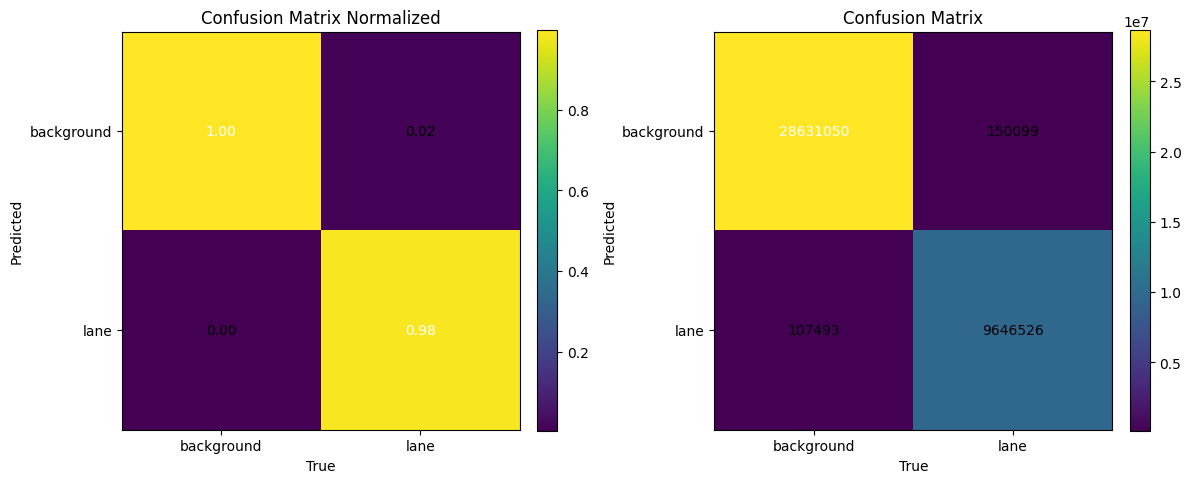

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# EVALUATION: Confusion Matrix + Metrics (Pixel-wise)
# ==========================

def compute_metrics_from_cm(cm):
    """
    cm format:
    [[TN, FP],
     [FN, TP]]
    """
    TN, FP, FN, TP = cm.ravel()

    acc = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    prec = TP / (TP + FP + 1e-8)
    rec = TP / (TP + FN + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    iou = TP / (TP + FP + FN + 1e-8)          # Jaccard/IoU for lane class
    dice = 2*TP / (2*TP + FP + FN + 1e-8)     # Dice for lane class

    return {
        "TN": int(TN), "FP": int(FP), "FN": int(FN), "TP": int(TP),
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "IoU (Lane)": iou,
        "Dice (Lane)": dice
    }

def confusion_matrix_binary(y_true_flat, y_pred_flat):
    """
    y_true_flat, y_pred_flat: 0/1 arrays (flatten)
    return cm = [[TN, FP],
                 [FN, TP]]
    """
    y_true_flat = y_true_flat.astype(np.uint8)
    y_pred_flat = y_pred_flat.astype(np.uint8)

    TP = np.sum((y_true_flat == 1) & (y_pred_flat == 1))
    TN = np.sum((y_true_flat == 0) & (y_pred_flat == 0))
    FP = np.sum((y_true_flat == 0) & (y_pred_flat == 1))
    FN = np.sum((y_true_flat == 1) & (y_pred_flat == 0))

    cm = np.array([[TN, FP],
                   [FN, TP]], dtype=np.int64)
    return cm

def plot_cm_side_by_side(cm, labels=("background", "lane"), save_path=None):
    """
    Plot confusion matrix:
    - Left: normalized (0-1)
    - Right: raw count
    normalized by TRUE class (column-wise), sama konsep contoh dosen kamu.
    """
    cm = np.array(cm, dtype=np.float32)
    cm_norm = cm / (cm.sum(axis=0, keepdims=True) + 1e-8)  # column-normalized

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Normalized ---
    im0 = axes[0].imshow(cm_norm)
    axes[0].set_title("Confusion Matrix Normalized")
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")
    axes[0].set_xticks([0,1]); axes[0].set_xticklabels(labels)
    axes[0].set_yticks([0,1]); axes[0].set_yticklabels(labels)
    for i in range(2):
        for j in range(2):
            axes[0].text(j, i, f"{cm_norm[i,j]:.2f}",
                         ha="center", va="center",
                         color="white" if cm_norm[i,j] > 0.5 else "black")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # --- Raw ---
    im1 = axes[1].imshow(cm)
    axes[1].set_title("Confusion Matrix")
    axes[1].set_xlabel("True")
    axes[1].set_ylabel("Predicted")
    axes[1].set_xticks([0,1]); axes[1].set_xticklabels(labels)
    axes[1].set_yticks([0,1]); axes[1].set_yticklabels(labels)
    for i in range(2):
        for j in range(2):
            axes[1].text(j, i, f"{int(cm[i,j])}",
                         ha="center", va="center",
                         color="white" if cm[i,j] > (cm.max()*0.5) else "black")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"[OK] Saved confusion matrix figure to: {save_path}")

    plt.show()

# ==========================
# RUN EVALUATION
# ==========================
THRESH = 0.5

# Predict on full validation set with batching to avoid OOM
y_pred_prob = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0)      # (N,H,W,1)
y_pred_bin  = (y_pred_prob > THRESH).astype(np.uint8)  # 0/1

y_true_flat = val_masks.reshape(-1).astype(np.uint8)
y_pred_flat = y_pred_bin.reshape(-1).astype(np.uint8)

cm = confusion_matrix_binary(y_true_flat, y_pred_flat)
metrics = compute_metrics_from_cm(cm)

print("\n=== CONFUSION MATRIX (Pixel-wise) ===")
print("Format: [[TN, FP],[FN, TP]]")
print(cm)

print("\n=== METRICS ===")
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k:12s}: {v:.4f}")
    else:
        print(f"{k:12s}: {v}")

# Plot + save image for PPT
plot_cm_side_by_side(cm, labels=("background","lane"), save_path="confusion_matrix_lane.png")

[OK] Saved metrics summary to: metrics_summary.png


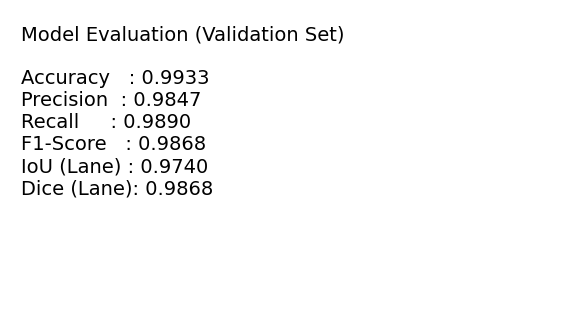

In [13]:
# Save a simple metrics summary image for PPT
fig = plt.figure(figsize=(7,4))
plt.axis("off")

lines = [
    "Model Evaluation (Validation Set)",
    "",
    f"Accuracy   : {metrics['Accuracy']:.4f}",
    f"Precision  : {metrics['Precision']:.4f}",
    f"Recall     : {metrics['Recall']:.4f}",
    f"F1-Score   : {metrics['F1']:.4f}",
    f"IoU (Lane) : {metrics['IoU (Lane)']:.4f}",
    f"Dice (Lane): {metrics['Dice (Lane)']:.4f}",
]
plt.text(0.02, 0.95, "\n".join(lines), va="top", fontsize=14)

plt.savefig("metrics_summary.png", dpi=200, bbox_inches="tight")
print("[OK] Saved metrics summary to: metrics_summary.png")
plt.show()


CELL 11 — Memory Cleanup (Run before kernel restart)

In [14]:
import gc

# Clear large numpy arrays
try:
    del train_images, train_masks, val_images, val_masks
    print("[OK] Cleared image arrays")
except:
    pass

# Clear model
try:
    del model
    print("[OK] Cleared model")
except:
    pass

# Force garbage collection
gc.collect()
print("[OK] Garbage collection done")

# Clear GPU memory
try:
    import tensorflow as tf
    tf.keras.backend.clear_session()
    print("[OK] GPU memory cleared")
except:
    pass

print("\n✓ Memory cleanup complete - safe to restart kernel now!")


[OK] Cleared image arrays
[OK] Cleared model
[OK] Garbage collection done
[OK] GPU memory cleared

✓ Memory cleanup complete - safe to restart kernel now!
